Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 5.1) 중고나라 핸드폰 거래가격 예측하기

### 바로가기

- [<Step1. 탐색적 분석> : 중고나라 데이터 분석](#<Step1.-탐색적-분석>-:-중고나라-데이터-분석)
    - [중고나라 데이터셋 살펴보기]
    - [개별 피처 탐색하기]
    - [Random forest regressor를 이용한 가격 예측]
- [<Step2. 피처 엔지니어링> : 예측 모델 개선](#<Step2.-피처-엔지니어링>-:-예측-모델-개선)
    - [기존 feature의 가공]
- [<Step3. 예측> : 중고폰 거래가 예측](#<Step3.-예측>-:-중고폰-거래가-예측)
    - [Random forest regressor 재학습]
    - [최적의 모델 파라미터 찾기]
- [<Step4. 프로토타입> : 얼마고(Almhago?)](#<Step4.-프로토타입>-:-얼마고(Almhago?))
    - ㅇㅁㅇㅁ

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색적 분석> : 중고나라 데이터 분석

### [중고나라 데이터셋 살펴보기]

In [2]:
df = pd.read_csv("../data/used_mobile_phone.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
create_date      4951 non-null object
price            4951 non-null float64
text             4951 non-null object
phone_model      4951 non-null object
factory_price    4951 non-null int64
maker            4951 non-null object
price_index      4951 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 270.8+ KB
None


,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


-----

### [개별 피처 탐색하기]

##### date 피처 탐색

In [3]:
# 월별 거래 횟수
df['month'] = df['create_date'].apply(lambda x: x[:7])
df['month'].value_counts()

2016-10    2956
2017-03    1311
2016-08     107
2016-09     105
2016-04     102
2016-05      89
2016-06      76
2016-07      74
2016-03      70
2016-02      61
Name: month, dtype: int64

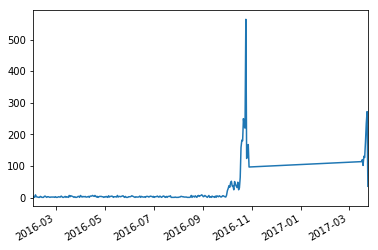

In [4]:
# 일별 거래 횟수
df_day = pd.to_datetime(df['create_date'].apply(lambda x: x[:10])).value_counts()
df_day.plot()
plt.show()

-----

##### 가격 피처 탐색

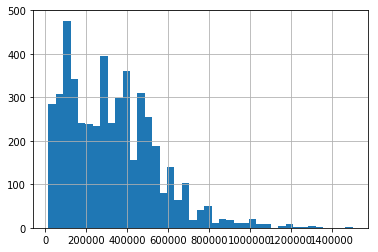

In [5]:
# 가격 분포 탐색
df['price'].hist(bins="auto")

In [6]:
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x))

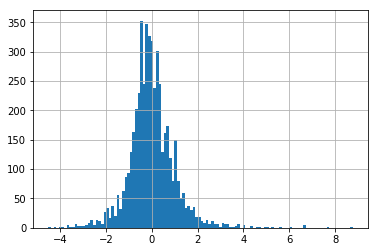

In [7]:
# 같은 모델내의 가격 분포 탐색
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x))
df_price_model_z_score = (df['price'] - df_price_model_mean) / df_price_model_std
df_price_model_z_score.hist(bins="auto")

-----

##### 출고가 피처 탐색

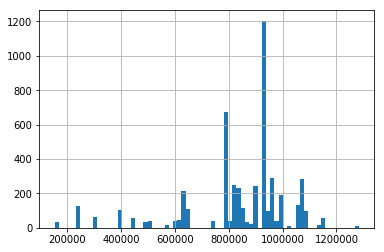

In [8]:
df['factory_price'].hist(bins="auto")

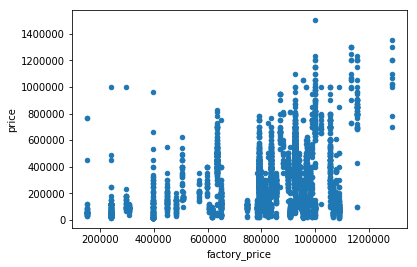

In [9]:
df.plot.scatter(x='factory_price', y='price')

-----

##### 핸드폰 모델 피처 탐색

count      64.000000
mean       77.359375
std       143.432786
min        10.000000
25%        23.000000
50%        35.000000
75%        90.500000
max      1002.000000
Name: phone_model, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x130144f28>,
 'caps': [<matplotlib.lines.Line2D at 0x13014f828>,
 'boxes': [<matplotlib.lines.Line2D at 0x130144dd8>],
 'medians': [<matplotlib.lines.Line2D at 0x13014ff60>],
 'fliers': [<matplotlib.lines.Line2D at 0x13014ff28>],
 'means': []}

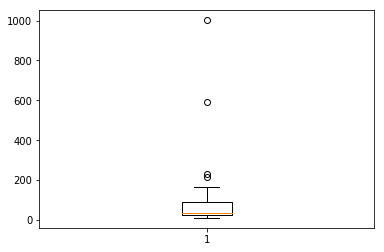

In [10]:
# 모델별 총 거래 데이터 개수
model_counts = df['phone_model'].value_counts()
print(model_counts.describe())
plt.boxplot(model_counts)

-----

##### 메이커 피처 탐색

apple      2450
samsung    1642
lg          677
pantech      57
sony         37
huawei       35
tg           28
sky          25
Name: maker, dtype: int64


{'whiskers': [<matplotlib.lines.Line2D at 0x13027fba8>,
 'caps': [<matplotlib.lines.Line2D at 0x13027ff60>,
 'boxes': [<matplotlib.lines.Line2D at 0x13027f828>],
 'medians': [<matplotlib.lines.Line2D at 0x13028a9b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x13028ac50>],
 'means': []}

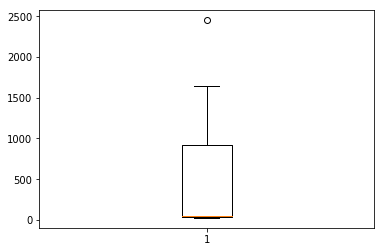

In [11]:
maker_counts = df['maker'].value_counts()
print(maker_counts)
plt.boxplot(maker_counts)

-----

##### 물가 피처 탐색

In [12]:
df['price_index'].value_counts()

103.05    3061
95.96     1311
102.59     448
94.90      131
Name: price_index, dtype: int64

-----

### [Random forest regressor를 이용한 가격 예측]

In [13]:
df.head()

,create_date,price,text,phone_model,factory_price,maker,price_index,month
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96,2017-03
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05,2016-10
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05,2016-10
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96,2017-03
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59,2016-04


-----

##### Random forest 모델 학습

In [14]:
# 분류 모델은 최종 단계에 하는 과정이기도 하지만, 그 이전에 변수의 중요도를 살펴보는 탐색적 분석의 과정에서도 중요한 역할을 할 수 있다.

MSE train: 10616489303.464, test: 13832465351.396
R^2 train: 0.781, test: 0.684


[('factory_price', 0.40713455001721993),
 ('maker_apple', 0.2970122545747388),
 ('phone_model_galaxy s3 3g 8gb', 0.021999674238838304),
 ('phone_model_iphone se 64gb', 0.021790840590572555),
 ('price_index', 0.020922724772652553),
 ('phone_model_galaxy s4 32gb', 0.016717973823351946),
 ('month_2017-03', 0.01490060985628339),
 ('maker_samsung', 0.014615333979110976),
 ('phone_model_galaxy s6 32gb', 0.012500838453066486),
 ('month_2016-05', 0.010991710925316573)]

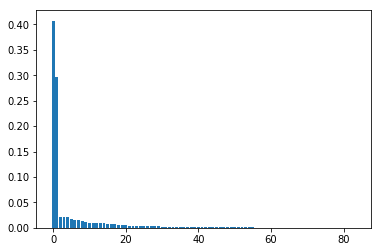

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 학습용 데이터 준비
df = df[['price', 'phone_model', 'factory_price', 'maker', 'price_index', 'month']]
df = pd.get_dummies(df, columns=['phone_model', 'maker', 'month'])
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 랜덤 포레스트 학습 및 평가
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 피처 중요도 plot
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 피처 중요도 print
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

In [16]:
# 영향력이 높은 month 순으로 출력
for sorted_feature in sorted(feature, key=lambda tup: tup[1], reverse=True):
    if "month" in sorted_feature[0]: 
        print(sorted_feature)

('month_2017-03', 0.01490060985628339)
('month_2016-05', 0.010991710925316573)
('month_2016-09', 0.008703641703833441)
('month_2016-04', 0.00758488315590149)
('month_2016-10', 0.0062864324840596125)
('month_2016-06', 0.00451022439204655)
('month_2016-08', 0.0037195927586660465)
('month_2016-07', 0.0026015173700873013)
('month_2016-03', 0.0023570298946857557)
('month_2016-02', 0.0009744825992722173)


-----

##### 예측 결과 scatter plot

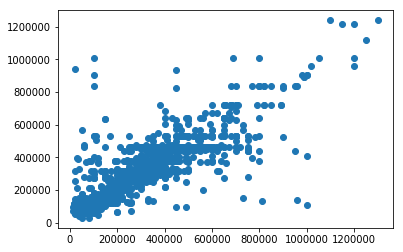

In [17]:
plt.scatter(y_test.values, y_test_pred)

-----

# <Step2. 피처 엔지니어링> : 예측 모델 개선

In [18]:
# 위에서 얻을 수 있었던 인사이트
# 1. 최근 게시물일수록 더 가격 예측에 중요한 게시물이다.
# 2. 가격은 같은 모델 내에서 정규 분포를 띠는 것 같다.
# 3. 출고가, 물가 데이터는 중고가 형성과 꽤나 관련이 있다
# 4. 애플 브랜드는 가격에 더 큰 영향을 미친다

# 피처 엔지니어링을 위한 가설 수립
# 1. 물품의 상태가 중고가에 영향을 미칠 것이며, 판매 게시글의 내용이 상품 상태에 유의미한 영향을 미칠 것이다
# 2. 핸드폰 모델은 용량별로 조금 더 세분화할 수 있을 것이다

### [기존 feature의 가공]

In [19]:
df = pd.read_csv("../data/used_mobile_phone.csv")

##### create_date로 시간점수 생성하기

In [20]:
from datetime import datetime
import time

def date_to_unixtime(date_str):
    timestamp = time.mktime(datetime.strptime(date_str, '%Y-%m-%d').timetuple())
    return timestamp

df['create_unixtime'] = df['create_date'].apply(lambda x: date_to_unixtime(x[:10]))
print(df['create_unixtime'][:10])

0    1.489849e+09
1    1.477408e+09
2    1.477321e+09
3    1.490195e+09
4    1.460300e+09
5    1.490108e+09
6    1.490195e+09
7    1.475766e+09
8    1.490368e+09
9    1.458659e+09
Name: create_unixtime, dtype: float64


In [21]:
df['create_time_score'] = (df['create_unixtime'] - df['create_unixtime'].min()) / \
                          (df['create_unixtime'].max() - df['create_unixtime'].min())
df[['create_date', 'create_unixtime', 'create_time_score']].head()

,create_date,create_unixtime,create_time_score
0,2017-03-19 4 35 00 PM,1.489849e+09,0.985612
1,2016-10-26 12 08 00 PM,1.477408e+09,0.640288
2,2016-10-25 12 52 00 PM,1.477321e+09,0.637890
3,2017-03-23 11 14 00 PM,1.490195e+09,0.995204
4,2016-04-11 7 35 00 PM,1.460300e+09,0.165468


-----

##### phone_model 피처 분리

In [22]:
df['phone_model_storage'] = df['phone_model'].apply(lambda x: x.split(" ")[-1])
df['phone_model_detail'] = df['phone_model'].apply(lambda x: ' '.join(x.split(" ")[:-1]))
df[['phone_model_storage', 'phone_model_detail']].head()

,phone_model_storage,phone_model_detail
0,64gb,iphone 6
1,32gb,galaxy s6 edge
2,32gb,galaxy s6
3,32gb,lg g5
4,32gb,lg u


{'whiskers': [<matplotlib.lines.Line2D at 0x1312255c0>,
 'caps': [<matplotlib.lines.Line2D at 0x131225c50>,
 'boxes': [<matplotlib.lines.Line2D at 0x131225240>,
 'medians': [<matplotlib.lines.Line2D at 0x13122e3c8>,
 'fliers': [<matplotlib.lines.Line2D at 0x13122e668>,
 'means': []}

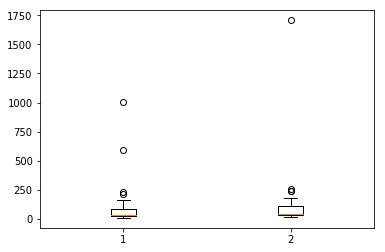

In [23]:
# 모델별 총 거래 데이터 개수 비교
model_counts = df['phone_model'].value_counts()
model_detail_counts = df['phone_model_detail'].value_counts()
data = [model_counts, model_detail_counts]
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.boxplot(data)

-----

##### phone_model 관련 딕셔너리 생성

In [24]:
# 모델명 + 용량으로 출고가를 찾을 수 있는 딕셔너리 생성
model_to_factory_price_dict = {}
for index, row in df.iterrows():
    model_concat = (row['phone_model_detail'], row['phone_model_storage'])
    if model_concat in model_to_factory_price_dict:
        pass
    else:
        model_to_factory_price_dict[model_concat] = row['factory_price']
print(str(model_to_factory_price_dict)[:40], "...")

{('iphone 6', '64gb'): 924000, ('galaxy  ...


-----

### [감성분석으로 물품의 상태 분류하기]

##### 감성분류의 정답 데이터셋 생성

-1.3966616903783375
1.666982156397844


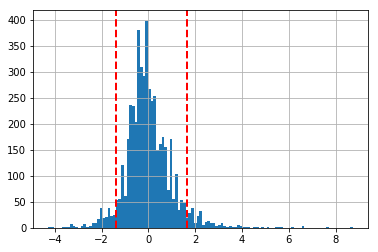

In [25]:
df['price_by_group'] = df.groupby('phone_model_detail')['price'].transform(lambda x: (x - x.mean()) / x.std())
ax = df['price_by_group'].hist(bins="auto")
lower_bound = df['price_by_group'].quantile(0.05)
upper_bound = df['price_by_group'].quantile(0.95)
ax.axvline(x=lower_bound, color='r', linestyle='dashed', linewidth=2)
ax.axvline(x=upper_bound, color='r', linestyle='dashed', linewidth=2)
print(lower_bound)
print(upper_bound)

In [26]:
def get_price_level(price, lower, upper):
    if price <= lower:
        return "0"
    elif price >= upper:
        return "2"
    else:
        return "1"

df['price_lower'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.05))
df['price_upper'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.95))
df['price_level'] = df.apply(lambda row: get_price_level(row['price'], row['price_lower'], row['price_upper']), axis=1)
df[['price', 'price_lower', 'price_upper', 'price_level', 'text']].head()



,price,price_lower,price_upper,price_level,text
0,550000.0,180000.0,680000.0,1,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...
1,380000.0,180000.0,414000.0,1,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...
2,300000.0,150000.0,349000.0,1,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...
3,290000.0,100000.0,500000.0,1,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...
4,280000.0,18000.0,400000.0,1,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...


-----

##### 텍스트 전처리

In [27]:
import pickle
import re

with open('../data/used_mobile_phone_stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)

def text_cleaning(text):
    text = ''.join(c for c in text if c.isalnum() or c in '+, ')
    text = ''.join([i for i in text if not i.isdigit()])
    return text

df['text'] = df['text'].apply(lambda x: text_cleaning(x))
print(stopwords[:10])

['거래', '입니', '판매', '아이폰', '갤럭시', '골드', '팝', '만원', '폰', '시']


-----

##### 형태소 단위로 추출

In [28]:
from konlpy.tag import Okt

def get_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] not in stopwords]

# 형태소 추출 동작 테스트
result = get_pos(df['text'][0])
print(result)

['+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '징', '애플', '라이트', '홈', '버튼', '링', '카메라', '링', '볼륨', '버튼', '슬립', '버튼', '검금', '심플', '튀지', '않게', '이쁘게', '했구요', '유심', '꽂고', '바로', '사용', '하시면', '됩니다', '사람', '이냐', '자주', '물어보고', '실제', '더욱', '이쁩니다', '밤', '영롱하게', '맥북', '뒷', '사과', '로고', '비춰지고', '요전', '넘어가기', '위해', '합니다', '가능합니다', '박스', '어머니', '버리시고', '이어폰', '충전기', '정품', '드립니다', '직거래', '우선', '순', '위로', '정', '싶으시면', '선', '입금', '택배', '발송', '해드리겠습니다', '믿으시면', '직거래', '하시길', '추천', '해요', '안전', '합니다', '서울시', '강남구', '역삼동', '차병원', '사거리', '근처', '가격']


-----

##### 빈출 단어 3000개 선정

In [29]:
from collections import Counter

# 빈출 단어 추출
corpus = sum(df['text'].apply(lambda x: get_pos(x)).tolist(), [])
counter = Counter(corpus)
counts = counter.most_common(2500)
common_words = [key for key, _ in counter.most_common(2500)]

counts

[('입니다', 6342),
 ('직거래', 5015),
 ('s', 4877),
 ('합니다', 4681),
 ('택배', 4276),
 ('사용', 3997),
 ('급', 3487),
 ('상태', 3373),
 ('팝니다', 3126),
 ('가능합니다', 2798),
 ('정상', 2769),
 ('사진', 2614),
 ('가격', 2542),
 ('+', 2443),
 ('케이스', 2314),
 ('a', 2276),
 ('주세요', 2229),
 ('해지', 2212),
 ('삭제', 2201),
 ('제품', 2198),
 ('있습니다', 2196),
 ('박스', 2123),
 ('가능', 2088),
 ('직접', 1954),
 ('액정', 1909),
 ('배터리', 1897),
 ('성품', 1783),
 ('필름', 1626),
 ('리퍼', 1488),
 ('충전기', 1371),
 ('없습니다', 1338),
 ('풀', 1273),
 ('개통', 1235),
 ('유심', 1219),
 ('즈', 1199),
 ('안전', 1146),
 ('스', 1093),
 ('하기', 1069),
 ('신청', 1052),
 ('드립니다', 1027),
 ('통신사', 1016),
 ('구입', 1012),
 ('약정', 1003),
 ('이어폰', 991),
 ('공기', 972),
 ('새', 968),
 ('기변', 962),
 ('포함', 953),
 ('모델', 953),
 ('선택', 908),
 ('됩니다', 849),
 ('확인', 799),
 ('기간', 760),
 ('기스', 731),
 ('그레이', 720),
 ('찍힘', 690),
 ('방법', 683),
 ('바로', 677),
 ('할인', 673),
 ('제', 663),
 ('시기', 642),
 ('스페이스', 636),
 ('희망', 632),
 ('번호', 632),
 ('중고나라', 624),
 ('본체', 622),
 ('같이', 621),
 ('

In [30]:
df['price_level'].value_counts()

1    4296
0     334
2     321
Name: price_level, dtype: int64

-----

##### TF-IDF 벡터 생성

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 빈출 단어를 제외한 모든 형태소 제거
def get_common_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] in common_words]

# 1:3:1 비율로 랜덤 샘플링
negative_random = df[df['price_level']=='0'].sample(321, random_state=30)
neutral_random = df[df['price_level']=='1'].sample(321*3, random_state=30)
positive_random = df[df['price_level']=='2'].sample(321, random_state=30)

# 샘플링 완료된 데이터셋
df_sample = negative_random.append(neutral_random).append(positive_random)

# TF-IDF
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_common_pos(x))
X = index_vectorizer.fit_transform(df_sample['text'].tolist())
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

# 감성 분류 학습 데이터셋
y = df_sample['price_level']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)
print(x_train.shape)
print(x_test.shape)

(1284, 2476)
(321, 2476)


-----

##### 상품 상태 분류하기

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# 비선형 SVM 분류기
svm = SVC(kernel='rbf', C=10.0, random_state=0, gamma=0.10)
svm.fit(x_train, y_train)
y_pred_ksvc = svm.predict(x_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_ksvc))
# pickle.dump(svm, open(os.path.join(dest, 'svm_for_textClassify.pkl'), 'wb')) 

Accuracy: 0.77


In [33]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_ksvc)
print(confmat)

[[ 30  28   4]
 [ 10 181  10]
 [  2  21  35]]


-----

# <Step3. 예측> : 중고폰 거래가 예측

### [Random forest regressor 재학습]

MSE train: 4765251251.217, test: 11043871624.009
R^2 train: 0.902, test: 0.747


[('maker_apple', 0.2533539302144926),
 ('factory_price', 0.2528236618371898),
 ('create_time_score', 0.11634729266698846),
 ('phone_model_storage_16gb', 0.06188147446151266),
 ('product_status_2', 0.048226413416876286),
 ('phone_model_detail_galaxy s7 edge', 0.02830993131641494),
 ('phone_model_storage_64gb', 0.025575874553524718),
 ('phone_model_detail_galaxy note5', 0.024251216617161928),
 ('phone_model_detail_galaxy s7', 0.022028339621623372),
 ('product_status_0', 0.021721112184317576)]

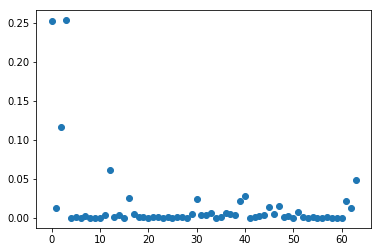

In [34]:
# Text 피처로 '상품 상태 피처' 생성
X = index_vectorizer.transform(df['text'].tolist())
X = tfidf_vectorizer.transform(X)
df['product_status'] = pd.Series(svm.predict(X))

# 모델링 데이터 준비
df = df[['price', 'factory_price', 'maker', 'price_index', 'create_time_score', 'phone_model_storage',
                'phone_model_detail', 'product_status']]
df = pd.get_dummies(df, columns=['maker', 'phone_model_storage', 'phone_model_detail', 'product_status'])

# Train, Test 데이터 분리
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 랜덤 포레스트 학습 및 평가
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 피처 중요도 plot
importances = forest.feature_importances_
plt.plot(importances, "o")

# 피처 중요도 print
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

------

##### feature-index 관련 딕셔너리 생성

In [35]:
col_to_index_dict = {}
for idx, col in enumerate(df.columns[1:]):
    col_to_index_dict[col] = idx
    
print(str(col_to_index_dict)[:40], "...")

{'factory_price': 0, 'price_index': 1, ' ...


-----

##### 예측 결과 scatter plot

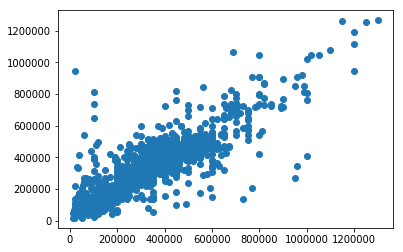

In [36]:
plt.scatter(y_test.values, y_test_pred)

-----

### [최적의 모델 파라미터 찾기]

In [37]:
from sklearn.model_selection import RandomizedSearchCV

# 파라미터 후보군 선정
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
bootstrap = [True, False]

# RandomizedSearchCV 오브젝트 생성
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
forest = RandomForestRegressor()
optimal_forest = RandomizedSearchCV(estimator = forest, 
                                    param_distributions = random_grid, 
                                    n_iter = 100, 
                                    cv = 3, 
                                    verbose=2,
                                    random_state=42, 
                                    n_jobs = -1)

# 모델 학습
X = df.loc[:, df.columns != 'price']
y = df['price']
optimal_forest.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.1min finished
/anaconda3/envs/yoon/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

-----

##### 최적 파라미터 출력

In [38]:
optimal_forest.best_params_

{'n_estimators': 2000,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

-----

##### 최적 모델 학습 결과

MSE train: 8808370716.999, test: 7645658262.568
R^2 train: 0.818, test: 0.825


[('factory_price', 0.29671418859366094),
 ('maker_apple', 0.2756146408805508),
 ('phone_model_storage_16gb', 0.07214403426570966),
 ('create_time_score', 0.06574407195616642),
 ('product_status_2', 0.06261278055598131),
 ('phone_model_detail_galaxy s7 edge', 0.027077101647140597),
 ('phone_model_detail_iphone 6', 0.025016635779217436),
 ('product_status_0', 0.02422754269717594),
 ('phone_model_detail_galaxy s4', 0.02053025350285394),
 ('product_status_1', 0.014045299203540071)]

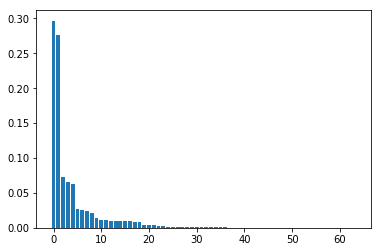

In [39]:
y_train_pred = optimal_forest.predict(X_train)
y_test_pred = optimal_forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 피처 중요도 plot
importances = optimal_forest.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 피처 중요도 print
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, optimal_forest.best_estimator_.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

-----

##### 예측 결과 scatter plot

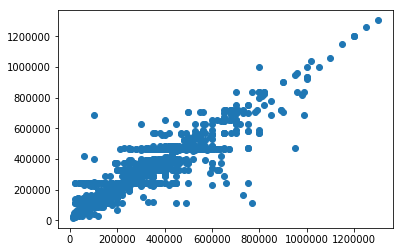

In [40]:
plt.scatter(y_test.values, y_test_pred)

In [41]:
#TF-IDF로 생성된 벡터를 회귀분석 모델의 피처로 사용하는 것도 좋은 방법이지만, 
#그러한 분석 방법을 수행하려면 조금 더 많은 것들을 배워야 하기 때문에 이번 예제에서는 회귀모델의 피처로 사용하지는 않도록 하겠습니다.

-----

# <Step4. 프로토타입> : 얼마고(Almhago?)

### [재사용을 위한 파일 저장]

In [42]:
with open('../data/used_mobile_pickles/model_to_factory_price_dict.pickle', 'wb') as f:
    pickle.dump(model_to_factory_price_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/col_to_index_dict.pickle', 'wb') as f:
    pickle.dump(col_to_index_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/common_words.pickle', 'wb') as f:
    pickle.dump(common_words, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'wb') as f:
    pickle.dump(index_vectorizer.vocabulary_, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/tfidf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/svm_classifier.pickle', 'wb') as f:
    pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/rf_regressor.pickle', 'wb') as f:
    pickle.dump(optimal_forest, f, pickle.HIGHEST_PROTOCOL)

-----

### [가격 예측 프로그램 만들기]

##### 예측에 필요한 파일 로드

In [43]:
import pickle

with open('../data/used_mobile_pickles/model_to_factory_price_dict.pickle', 'rb') as f:
    model_to_factory_price_dict = pickle.load(f)
    
with open('../data/used_mobile_pickles/col_to_index_dict.pickle', 'rb') as f:
    col_to_index_dict = pickle.load(f)
    
with open('../data/used_mobile_pickles/common_words.pickle', 'rb') as f:
    common_words = pickle.load(f)

with open('../data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'rb') as f:
    init_vectorizer_vocabulary = pickle.load(f)
    
with open('../data/used_mobile_pickles/tfidf_vectorizer.pickle', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
    
with open('../data/used_mobile_pickles/svm_classifier.pickle', 'rb') as f:
    svm_classifier = pickle.load(f)

with open('../data/used_mobile_pickles/rf_regressor.pickle', 'rb') as f:
    rf_regressor = pickle.load(f)

-----

##### 프로그램(함수) 만들기

In [44]:
import numpy as np

from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


class Almhago():
    def __init__(self, model_to_factory_price_dict, col_to_index_dict, 
                 common_words, init_vectorizer_vocabulary, tfidf_vectorizer, 
                 prd_status_classifier, price_regressor):
        self._model_to_factory_price_dict = model_to_factory_price_dict
        self._col_to_index_dict = col_to_index_dict
        self._common_words = common_words
        self._init_vectorizer_vocabulary = init_vectorizer_vocabulary
        self._index_vectorizer = self._init_index_vectorizer()
        self._tfidf_vectorizer = tfidf_vectorizer
        self._prd_status_classifier = prd_status_classifier
        self._price_regressor = price_regressor
        
    def _get_common_pos(self, x):
        tagger = Okt()
        poses = tagger.pos(x)
        return [pos[0] for pos in poses if pos[0] in self._common_words]
    
    def _text_cleaning(self, text):
        text = ''.join(c for c in text if c.isalnum() or c in '+, ')
        text = ''.join([i for i in text if not i.isdigit()])
        return text
        
    def _init_index_vectorizer(self):
        word_index_vectorizer = CountVectorizer(tokenizer = lambda x: self._get_common_pos(x))
        word_index_vectorizer.vocabulary_ = self._init_vectorizer_vocabulary
        return word_index_vectorizer
    
    def _get_ftr_price(self, model_name, storage):
        return self._model_to_factory_price_dict[(model_name, storage)]
    
    def _get_prd_status(self, text):
        X = self._index_vectorizer.transform([self._text_cleaning(program_test_dict['text'])])
        X = self._tfidf_vectorizer.transform(X)
        return self._prd_status_classifier.predict(X)[0]
    
    def _print_almhago(self, model, price, prd_status):
        status = ""
        if prd_status == "0":
            status = "불량한"
        elif prd_status == "1":
            status = "양호한"
        else:
            status = "좋은"
        print("선택하신", model, "모델은", status, "상태입니다. Almhago 예상 가격은", str(int(price[0])), "원 입니다.")
    
    def predict(self, input_dict):
        feature = np.zeros(64)
        feature[self._col_to_index_dict['factory_price']] = self._get_ftr_price(input_dict['phone_model_detail'],
                                                                                input_dict['phone_model_storage'])
        feature[self._col_to_index_dict['price_index']] = input_dict['price_index']
        feature[self._col_to_index_dict['create_time_score']] = input_dict['create_time_score']
        feature[self._col_to_index_dict["_".join(["maker", input_dict['maker']])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_detail", input_dict['phone_model_detail']])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_storage", input_dict['phone_model_storage']])]] = 1
        feature[self._col_to_index_dict["_".join(["product_status", self._get_prd_status(input_dict['text'])])]] = 1
        
        # predict result
        predicted_price = self._price_regressor.predict([feature])
        self._print_almhago(input_dict['phone_model_detail'], 
                            predicted_price, 
                            self._get_prd_status(input_dict['text']))

-----

##### 프로그램 테스트

In [45]:
recent_price_index = 95.96
recent_create_time_score = 1.0
program_test_dict = {"maker": "apple",
                     "phone_model_detail": "iphone 6",
                     "phone_model_storage": "16gb",
                     "text": '아이폰6 스페이스그레이 16기가 10만원에 팔아요~ 직접거래 \
                     메인보드 세척 완료 한 침수 폰 입니다폰 안켜지는 상테이구요 고쳐서 쓰실분 가져가세요10만원에 팔아요 \
                     리퍼한지 얼마안되서 기스 이런거 하나도 없습니당~서울 강남 근처 직거래 가능하며택배거래도 가능해요',
                     "price_index": recent_price_index,
                     "create_time_score": recent_create_time_score}

almhago = Almhago(model_to_factory_price_dict, col_to_index_dict, 
                  common_words, init_vectorizer_vocabulary, tfidf_vectorizer, 
                  svm_classifier, rf_regressor)
almhago.predict(program_test_dict)

선택하신 iphone 6 모델은 불량한 상태입니다. Almhago 예상 가격은 152307 원 입니다.
